# Sequestration Data Preparation in a VM
---
by Eric Giger

Data Submission Technician at the Center for Translational Data Science at the University of Chicago

December 2022

---

In MIDRC, some of the data is sequestered for the sake of validation and testing, which will provide a valuable resource for data science challenges and a path to long-term sustainability through industry support for translation to - and approval of - clinical use which will impact public health worldwide.

To learn more about MIDRC, please visit [www.midrc.org](https://www.midrc.org).

If you would like to learn more about sequestration, there is a MIDRC Seminar on the topic: [https://www.youtube.com/watch?v=53g74qIdOp8](https://www.youtube.com/watch?v=53g74qIdOp8)

## Getting Started: Locally
We must first upload our ValidateStaging credentials to the utilityvm. \
The credentials will be used to configure our gen3 profile and will later be used to upload the sequestration data file to [ValidateStaging](https://validatestaging.midrc.org/).

As a reminder, credentials can be downloaded from your Profile Page at the [/identity](https://validatestaging.midrc.org/identity) endpoint.

In [ ]:
# Upload your ValidateStaging credentials to the VM
import sys, os
# this is the path to your credentials file LOCALLY, to be uploaded to the VM
# they should be of the form "midrc-validatestaging-credentials.json" 
# as to note confuse them with credentials for other environments

user=""
cred_path = "/Users/{}/Downloads/midrc-validatestaging-credentials.json".format(user) 
os.system("rsync -rP {} utilityvm.midrc.csoc:~/wd/creds/midrc-validatestaging-credentials.json".format(cred_path))

## Getting Started: In the VM

### For the rest of this notebook, you will have to copy and paste into an `ipython3` shell in the utilityvm. 

Before you begin, the metadata TSVs must already be pulled down from S3 into the VM. Instructions for such are not included in this notebook.

In [ ]:
# Import Python Packages and scripts
import pandas as pd
import sys, os, copy, datetime, glob
import numpy as np
import json

In [ ]:
# Configure your gen3-client profile
profile = "midrc-validatestaging"
api="https://validatestaging.midrc.org"
vm_cred_path = "/home/ubuntu/wd/creds/midrc-validatestaging-credentials.json"

os.system("gen3-client configure --profile={} --apiendpoint={} --cred={}".format(profile,api,vm_cred_path))

In [ ]:
# Set your working directory in the VM and change to it
seq_dir = "/home/ubuntu/wd/sequestration"
os.chdir(seq_dir)

## Begin Processing the Metadata

In [ ]:
print("""
                        !    IMPORTANT   !
    Remember to change org (ACR or RSNA) and date (YYYYMMDD)
""")

In [ ]:
# Define the batch
org = ""
date = ""
batch_name = "{}_{}".format(org,date)

print('Extracting data for sequestration from {}.'.format(batch_name))

In [ ]:
# Read in the Master Sequestration Locations List

masterfile = glob.glob("/home/ubuntu/wd/master_sequestration_locations_*.tsv")
mf = pd.read_csv(masterfile[0],sep='\t') #
mf_length = len(list(mf.case_ids)) # 
print("There are {} cases in this master sequestration list.".format(mf_length))

### Case Metadata

We will collect the following metadata from the “case_ORG_DATE.tsv”:
* submitter_id (case or patient ID)
* project_id
* age_at_index
* age_at_index_gt89
* covid19_postive
* ethnicity
* race
* sex
* site_id

In [ ]:
# Read in the “case_ORG_DATE.tsv”

casefile = "/home/ubuntu/download/{}/case_{}.tsv".format(batch_name,batch_name)
cf = pd.read_csv(casefile,sep='\t') #
cf['case_ids']=cf['submitter_id']
unique_cases = len(list(set(cf.submitter_id)))

if org == 'ACR':
    cf['project_id']='Open-A1'
elif org == 'RSNA':
    cf['project_id']='Open-R1'
display(set(cf.project_id))

In [ ]:
# Let's take a peak at the case TSV we have just read into a DataFrame
display(cf)

In [ ]:
# Check to make sure there are not duplicate submitter_id/case_ids

if len(cf)==unique_cases:
    print("There are {} records for {} unique case_ids. Please proceed!".format(len(cf),unique_cases))
elif len(cf) > unique_cases:
    print("Error: Potential Duplicates! Please Stop!")

### Imaging Study Metadata

We will collect the following metadata from the “imaging_study_ORG_DATE.tsv”:

* case_ids
* study_modality
* study_description
* body_part_examined

In [ ]:
# Read in the “imaging_study_ORG_DATE.tsv”

imagingfile = "/home/ubuntu/download/{}/imaging_study_{}.tsv".format(batch_name,batch_name)
imf = pd.read_csv(imagingfile,sep='\t')
len(list(set(imf.submitter_id)))
imf['study_uid']=imf['submitter_id']
unique_studies = len(list(set(imf.submitter_id)))

In [ ]:
# Let's take a peak at the imaging_study TSV we have just read into a DataFrame
display(imf)

In [ ]:
# Check to make sure there are not duplicate submitter_id/study_uids
if len(imf)==unique_studies:
    print("There are {} records for {} unique study_uids. Please proceed!".format(len(imf),unique_studies))
elif len(imf) > unique_studies:
    print("Error: Potential Duplicates! Please Stop!")

In [ ]:
# Let's make a subset of the imaging_study metadata 
# This subset of the imaging_study TSV contains only the needed imaging_study metadata for sequestration
st = copy.deepcopy(imf[['case_ids','study_modality','study_description','body_part_examined']].drop_duplicates(subset='case_ids'))  # 8020
len(list(set(st.case_ids)))

display(st)
old_sm = set(st.study_modality)
display(old_sm)

In [ ]:
# Flatten the imaging_study modality metadata to prepare for merge with case metadata
st.index = st.case_ids
stids = list(set(st.case_ids))
for stid in stids: # stid = stids[0]
    mods = list(set(imf.loc[(imf['case_ids']==stid) & ~(imf['study_modality'].isna())]['study_modality']))
    #print("{}:{}".format(sid,vps))
    if mods != [np.nan]:
        study_modality = ",".join(mods)
    st.at[stid,'study_modality'] = study_modality
    
display(st)
new_sm = set(st.study_modality)
display(new_sm)

In [ ]:
print("Take notice of the differences in 'set(st.study_modality)' before and after 'flattening' the property.")
display(old_sm)
print("     VS     ")
display(new_sm)

In [ ]:
# merge imaging_study metadata onto case metadata

i = pd.merge(cf[['project_id','case_ids','age_at_index','age_at_index_gt89','covid19_positive','ethnicity','race','sex','site_id']],st.reset_index(drop=True),on='case_ids',how='left')

In [ ]:
## check lengths to confirm there is no loss of case metadata 
assert(len(list(set(i.case_ids)))==len(list(set(cf.submitter_id))))

Add the sequestration locations of case IDs that are already in the master list (merge the ‘dataset’ column from the master list on the “case_ids” columns).


In [ ]:
# Add the sequestration locations of case IDs that are already in the master list 
# (merge the ‘dataset’ column from the master list on the “case_ids” columns)

file = pd.merge(i,mf[['dataset','case_ids']],on='case_ids',how='left')
file.rename(columns={'case_ids':'submitter_id','study_modality':'modality'},inplace=True)

display(set(file.dataset))
# We should expect to see 'Open','Seq', or 'NaN'

In [ ]:
# set the dataset for new cases (i.e., not in the masterlist) to Unassigned
file.loc[file["dataset"].isna(),"dataset"] = "Unassigned"

display(set(file.dataset))

In [ ]:
# get the number of Open, Seq, and Unassigned cases 
# this will be used when emailing the UC team the data is ready

display(file['dataset'].value_counts())

## Save the File

In [ ]:
os.chdir("{}/{}/".format(seq_dir,org))
file_name = "sequestration_data_{}_{}.tsv".format(org,date)
file.to_csv(file_name, sep='\t', index=False)

## Upload the File

In [ ]:
file_path = "{}/{}/{}".format(seq_dir,org,file_name)
profile = "midrc-validatestaging"
os.system("gen3-client upload --profile={} --upload-path={}".format(profile,file_path))

## Create 'dataset' and 'core_metadata_collections' nodes for batch

In [ ]:
### Initialize Gen3 Classes
import gen3
from gen3.submission import Gen3Submission
from gen3.auth import Gen3Auth
from gen3.index import Gen3Index
from gen3.query import Gen3Query

api = 'https://validatestaging.midrc.org'
cred = "/home/ubuntu/wd/creds/midrc-validatestaging-credentials.json"
auth = Gen3Auth(api, refresh_file=cred)
sub = Gen3Submission(api, auth)

In [ ]:
# Create 'dataset' node for batch
pid = "SEQ_Restricted-DT"
prog,proj = pid.split("-",1)
dataset_txt = """{
        "type": "dataset",
        "data_contributor": "%s",
        "data_description": "%s",
        "projects": [
            {
                "code": "DT"
            }
        ],
        "submitter_id": "%s"
    }""" % (org,batch_name,batch_name)

dataset_json = json.loads(dataset_txt)
data = sub.submit_record(program=prog, project=proj, json=dataset_json)
print(data)

# Create 'core_metadata_collections' node for batch
cmc_txt = """{
        "description": "Sequestration Data from the batch %s.",
        "submitter_id": "%s",
        "title": "%s",
        "project_id": "%s",
        "type": "core_metadata_collection",
        "projects": [
            {
                "code": "%s"
            }
        ]
    }""" % (batch_name,batch_name,batch_name,pid,proj)

cmc_json = json.loads(cmc_txt)
data = sub.submit_record(program=prog,project=proj,json=cmc_json)
print(data)

## Map the File

* `Project`: SEQ_Restricted-DT

* `File Node`: supplementary_file

* `data_category`: Case Sequestration Metadata

* `data_type`: Case Sequestration Metadata

* `data_format`: TSV

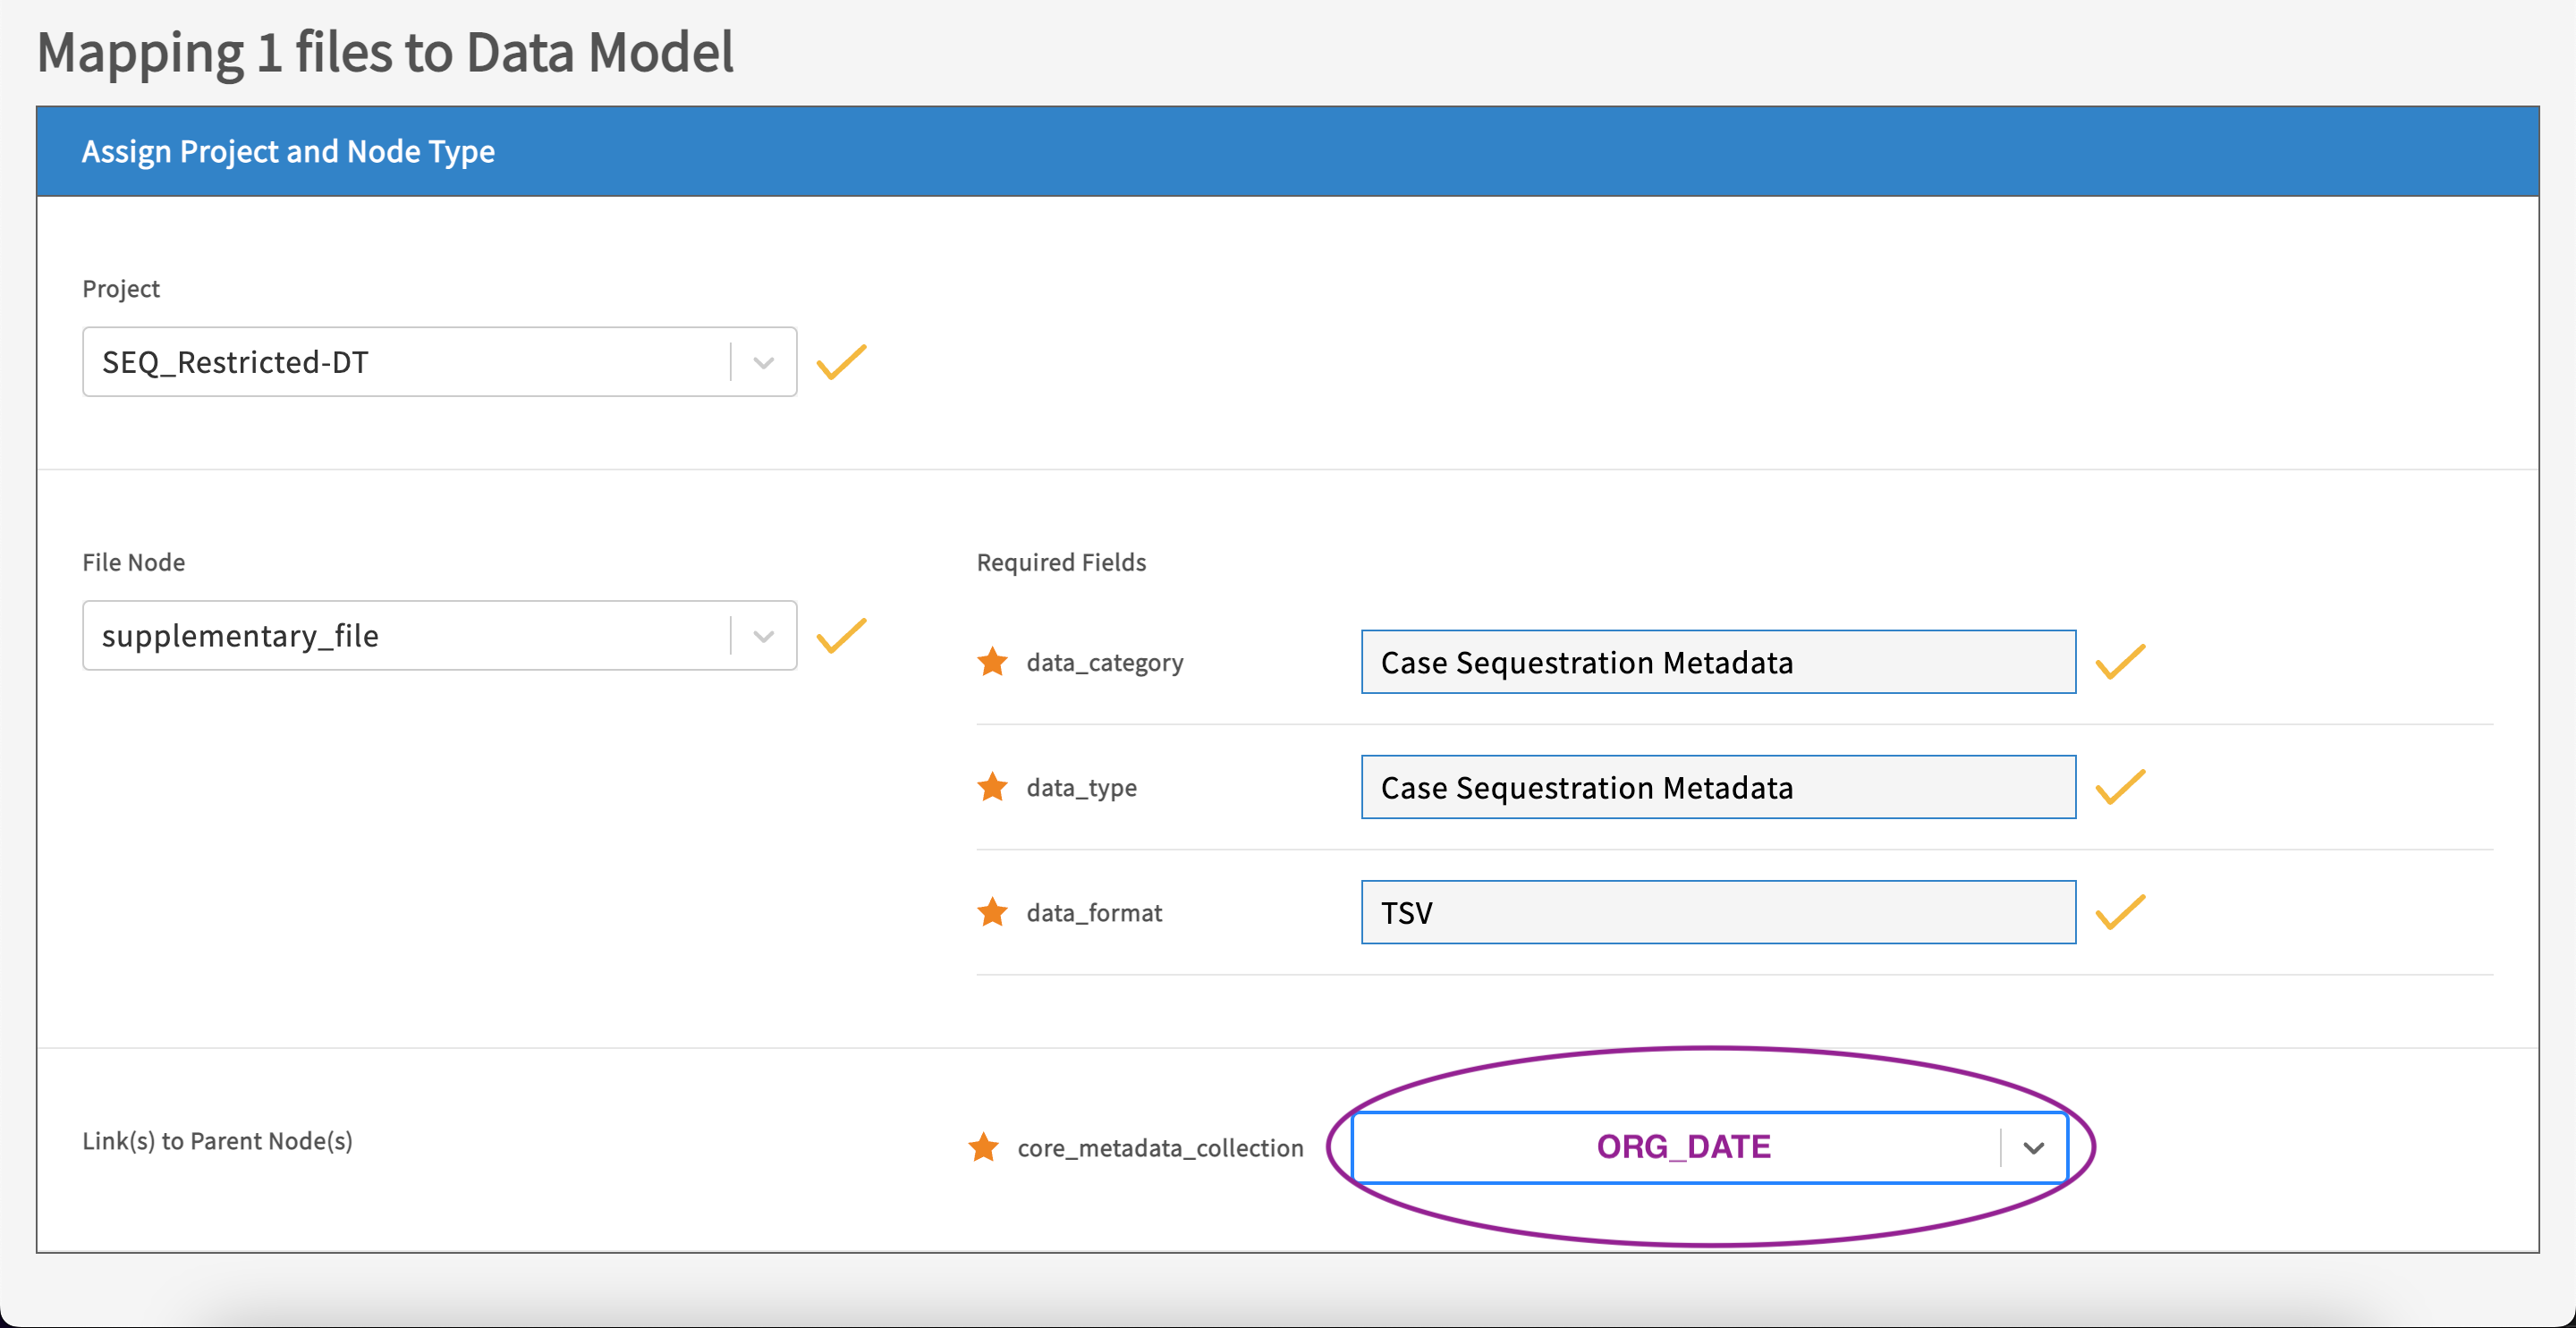

# Notify UC-MIDRC team that the data is ready for sequestration 

When emailing, it is a nice touch to add the the counts of 'Open', 'Seq', and 'Unassigned' cases. \
This can be easily grabbed from `display(file['dataset'].value_counts())`